# Calculo de LNA con microtiras
El cálculo de microtiras depende de los parámetros físicos del sustrato que vamos a usar.

In [1]:
import numpy as np
import skrf as rf
from microstrip import w_microstrip, QW_microstrip
from IPython.display import Image

# Parámetros
f = 1.85e9
Zo = 50
VCE = 3
IC = 80
e_r = 4 #permitividad relativa
H = 1.66e-3
t = 0.04e-3 #espesor del conductor

Buscamos el archivo S2P con curvas

In [2]:

file = './BFP450/' + f'BFP450_w_noise_VCE_{VCE:.1f}V_IC_{IC:.0f}mA.s2p'
ntwk = rf.Network(file)
i = (np.abs(ntwk.f - f)).argmin()
S = ntwk.s[i]


Los coeficiente de reflexión están dados por

$\rho_{S(m)} = \rho_{in}^* = \frac{B_1 - \sqrt{B_1^2 - 4|C_1|^2}}{2C_1}$

$\rho_{L(m)} = \rho_{out}^* = \frac{B_2 - \sqrt{B_2^2 - 4|C_2|^2}}{2C_2}$

$\begin{cases} B_1 = 1 + |S_{11}|^2 - |S_{22}|^2 - |\Delta|^2 = 0.7865 \\ B_2 = 1 + |S_{22}|^2 - |S_{11}|^2 - |\Delta|^2 = 0.3032 \\ C_1 = S_{11} - (\Delta S_{22}^*) = -0.3671 + j0.1021 \\ C_2 = S_{22} - (\Delta S_{11}^*) = -0.1038 - j0.0523 \end{cases}$


In [3]:
Delta = S[0, 0] * S[1, 1] - S[0, 1] * S[1, 0]
abs_Delta = np.abs(Delta)
k = (1 - np.abs(S[0, 0]) ** 2 - np.abs(S[1, 1]) ** 2 + abs_Delta ** 2) / (
    2 * np.abs(S[0, 1] * S[1, 0]))
print(k)
# Cálculos de reflexión
B1 = 1 + np.abs(S[0, 0]) ** 2 - np.abs(S[1, 1]) ** 2 - abs_Delta ** 2
B2 = 1 + np.abs(S[1, 1]) ** 2 - np.abs(S[0, 0]) ** 2 - abs_Delta ** 2
C1 = S[0, 0] - Delta * np.conj(S[1, 1])
C2 = S[1, 1] - Delta * np.conj(S[0, 0])

# Coefcientes de reflexión adaptados
r_Ms = (B1 - np.sqrt(B1 ** 2 - 4 * np.abs(C1) ** 2)) / (2 * C1) if B1 > 0 else (B1 + np.sqrt(B1 ** 2 - 4 * np.abs(C1) ** 2)) / (2 * C1)
r_ML = (B2 - np.sqrt(B2 ** 2 - 4 * np.abs(C2) ** 2)) / (2 * C2) if B2 > 0 else (B2 + np.sqrt(B2 ** 2 - 4 * np.abs(C2) ** 2)) / (2 * C2)

# Coeficientes de reflexión en la entrada y salida
r_in = np.conj(r_Ms)
r_out = np.conj(r_ML)

1.0834964262536586


La impedancia de entrada y salida del transistor, con 
$$Z_0 = 50\Omega$$$$Z_{in} = Z_0 \frac{1 + \rho_{in}}{1 - \rho_{in}}$$
$$Z_{out} = Z_0 \frac{1 + \rho_{out}}{1 - \rho_{out}}$$

In [4]:
Z_in = Zo * (1 + r_in) / (1 - r_in)
Z_out = Zo * (1 + r_out) / (1 - r_out)

## Adaptación a la entrada
Para adaptar a la entrada, debemos pasar a modelo paralelo y cancelar la reactancia de la entrada con un capacitor, mientras adaptamos la parte resistiva con un transformador de $\lambda / 4$.

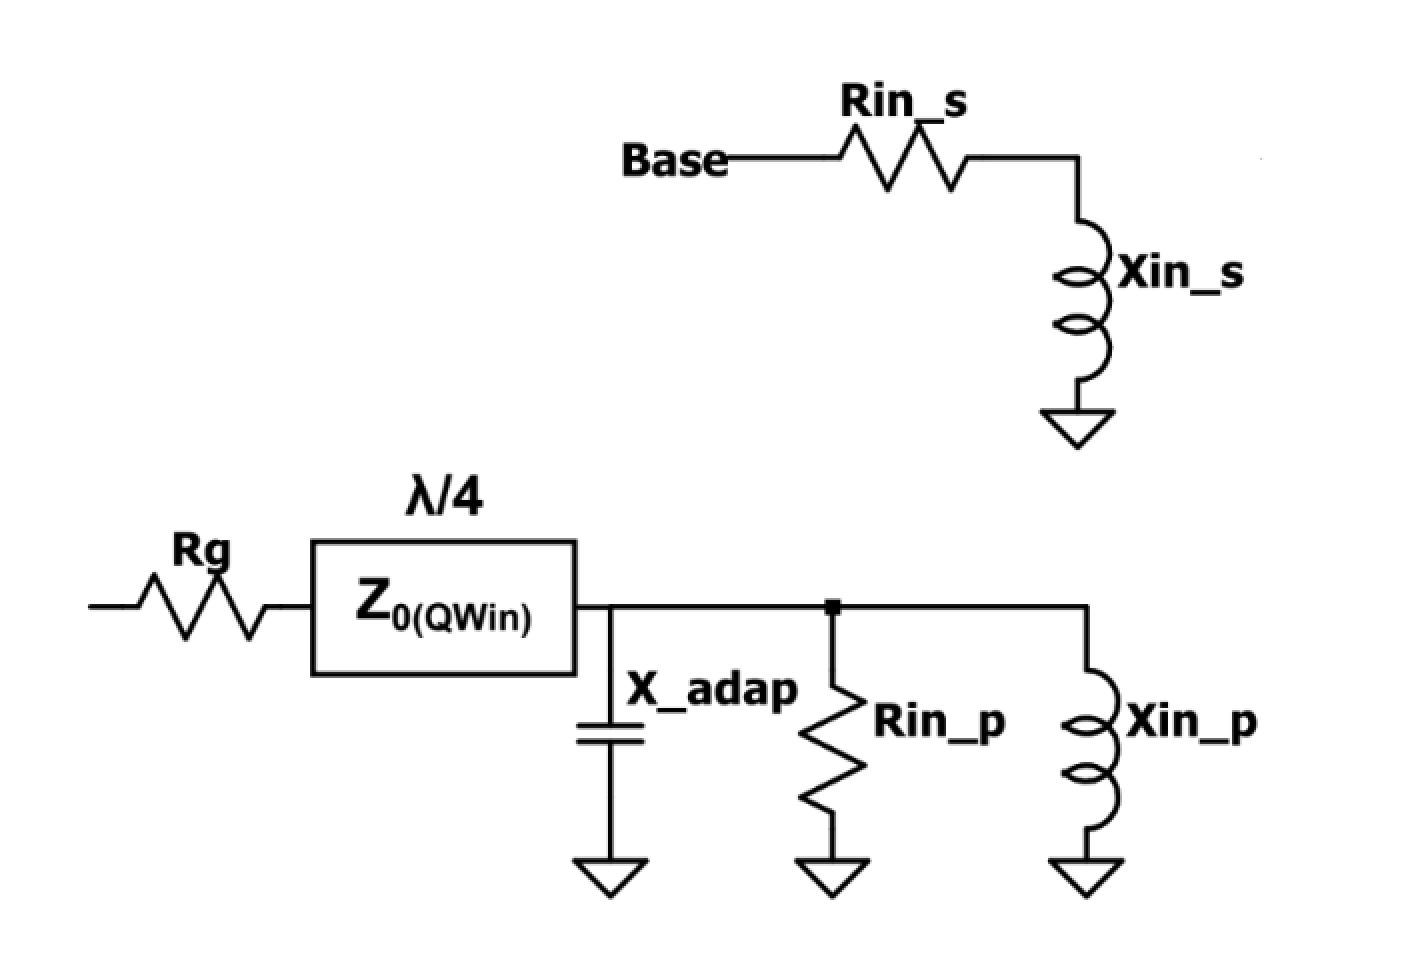

In [5]:
Image('./img/adaptacion_entrada.png', width=400)

In [6]:
Rin_s = np.real(Z_in) #Resistencia de entrada SERIE
Xin_s = np.imag(Z_in) #Reactancia de entrada SERIE
Rin_p = Rin_s * (1 + (Xin_s / Rin_s) ** 2) #Resistencia de entrada PARALELO
Xin_p = Rin_s * (Rin_p / Xin_s) #Reactancia de entrada PARALELO
Cin_adap = 1 / (2 * np.pi * f * Xin_p) #Capacidad que cancela la inductancia de entrada.

Z1 = np.sqrt(Rin_p * Zo) 
print(Z1)
QWin_ms = QW_microstrip(e_r, H, t, Z1, f) #Microtira del QWT de entrada

beta_in = (2 * np.pi) / QWin_ms['Lambda_p']
d_cap_in = (1 / beta_in) * np.arctan(Zo/Xin_p)
Cin_ms = w_microstrip(e_r, H, t, Zo, f)#Capacitor sintetizado
Cin_ms.update({'d':d_cap_in})

26.458531549479982


## Adaptación a la salida
Caso similar a la entrada

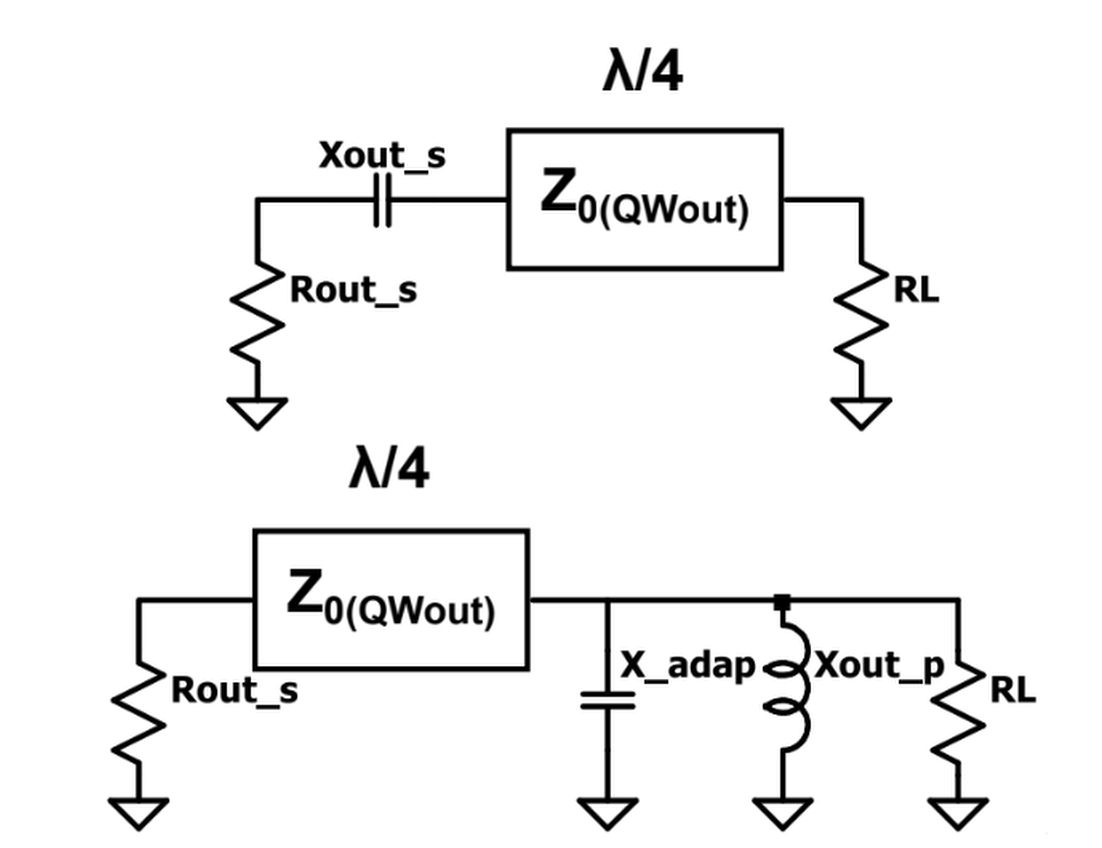

In [7]:
Image('./img/adaptacion_salida.png', width=400)

In [8]:
Rout_s = np.real(Z_out) #Resistencia de salida SERIE
Xout_s = np.imag(Z_out) #Reactancia de salida SERIE
Z2 = np.sqrt(Rout_s * Zo)
print(Z2)
QWout_ms = QW_microstrip(e_r, H, t, Z2, f)
X_adap = -(Zo ** 2) / Xout_s
Cout_adap = 1 / (2 * np.pi * f * X_adap)
beta_out = (2 * np.pi) / QWout_ms['Lambda_p']
d_cap_out = (1 / beta_out) * np.arctan(Zo/X_adap)
Cout_ms = w_microstrip(e_r, H, t, Zo, f) #Capacitor sintetizado
Cout_ms.update({'d':d_cap_out})

34.721580742030554


In [9]:
import pandas as pd
pd.set_eng_float_format(accuracy=3)
pd.DataFrame([QWin_ms, Cin_ms, QWout_ms, Cout_ms], index=['QWin_ms', 'Cin_ms', 'QWout_ms', 'Cout_ms'])


,We,Zo,Lambda_p,d
QWin_ms,8.587E-03,26.630E+00,88.985E-03,22.246E-03
Cin_ms,3.448E-03,50.354E+00,92.532E-03,18.543E-03
QWout_ms,5.955E-03,35.006E+00,90.420E-03,22.605E-03
Cout_ms,3.448E-03,50.354E+00,92.532E-03,4.557E-03


In [10]:
pd.DataFrame([[Cin_adap, Cout_adap]], columns=['Cin_adap', 'Cout_adap'])

,Cin_adap,Cout_adap
0,6.429E-12,563.875E-15


### Ajuste fino con tunning del simulador.
Se realiza ajuste fino con tunning del simulador, los valores obtenidos son: (DESACTUALIZADO, COMPROBAR)
| C       | d          | W        |
| ------- | ---------- | -------- |
| Cin_ms  | 19.6468 mm | 3.325 mm |
| Cout_ms | 13.8703 mm | 3.325 mm |


### Corrección de microtiras de capacitores por los taper
Hay que mantener el $A_{C_{in}}$ y el $A_{C_{out}}$ constante para la implementación de los taper.

In [11]:
Cin_tapper = dict(W1 = 1.5e-3, W2 = Cin_ms['We'], d = 3e-3) 
Cout_tapper = dict(W1 = 1.5e-3, W2 = Cout_ms['We'], d = 3e-3) 

Cin_ms['dwtapper'] = Cin_ms['d']- Cin_tapper['d']
Cout_ms['dwtapper'] = Cout_ms['d']- Cout_tapper['d']

pd.DataFrame([Cin_tapper, Cout_tapper, Cin_ms, Cout_ms], index=['Cin_tapper', 'Cout_tapper', 'Cin_ms', 'Cout_ms'])[['d', 'dwtapper', 'We']]

,d,dwtapper,We
Cin_tapper,3.000E-03,NaN,NaN
Cout_tapper,3.000E-03,NaN,NaN
Cin_ms,18.543E-03,15.543E-03,3.448E-03
Cout_ms,4.557E-03,1.557E-03,3.448E-03


### Ajuste fino de microtiras por tapper
Ajuste fino usando tunning de las microtiras: (DESACTUALIZADO, COMPROBAR)

| C       | d          | W        |
| ------- | ---------- | -------- |
| Cin_ms  | 16.2468 mm | 3.325 mm |
| Cout_ms | 10.9703 mm | 3.325 mm |

## Polarización
- Sintetizar microtiras de Inductor de Choque con impedancia característica alta: $100\Omega$ a $250\Omega$
- Sintetizar microtiras de Capacitor de desacople con impedancia característica baja: $20\Omega$ a $60\Omega$

Aparte, tambien se sintetizan las microtiras de lineas de transmision.

In [12]:
Lch_ms = QW_microstrip(e_r, H, t, 80, f)
Cdecoup_ms = QW_microstrip(e_r, H, t, 30, f)
Zo_TL_ms = w_microstrip(e_r, H, t, Zo, f)
pd.DataFrame([Lch_ms, Cdecoup_ms, Zo_TL_ms], index=['Lch_ms', 'Cdecoup_ms', 'Zo_TL_ms'])

,We,Zo,Lambda_p,d
Lch_ms,1.483E-03,79.902E+00,95.451E-03,23.863E-03
Cdecoup_ms,7.275E-03,30.216E+00,89.633E-03,22.408E-03
Zo_TL_ms,3.448E-03,50.354E+00,92.532E-03,NaN


### Corrección de microtiras por tappers
Hay que mantener el $A_{L_{ch}}$ y el $A_{C_{decoup}}$ constante para la implementación de los taper.

In [13]:
Cdecoup_tapper = dict(W1 = 1e-3, W2 = Cdecoup_ms['We'], d = 3e-3) 
Lch_tapper = dict(W1 = 1e-3, W2 = Lch_ms['We'], d = 3e-3) 

Cdecoup_tapper['A'] = (Cdecoup_tapper['W1'] + Cdecoup_tapper['W2']) * Cdecoup_tapper['d']/2 
Lch_tapper['A'] = (Lch_tapper['W1'] + Lch_tapper['W2']) * Lch_tapper['d']/2
Cdecoup_ms['dwtapper'] = Cdecoup_ms['d']- Cdecoup_tapper['A']/Cdecoup_tapper['W2']
Lch_ms['dwtapper'] = Lch_ms['d']- Lch_tapper['A']/Lch_tapper['W2']

pd.DataFrame([Cdecoup_tapper, Lch_tapper, Cdecoup_ms, Lch_ms], index=['Cdecoup_tapper', 'Lch_tapper', 'Cdecoup_ms', 'Lch_ms'])[['d', 'A', 'dwtapper', 'We']]

,d,A,dwtapper,We
Cdecoup_tapper,3.000E-03,12.413E-06,NaN,NaN
Lch_tapper,3.000E-03,3.724E-06,NaN,NaN
Cdecoup_ms,22.408E-03,NaN,20.702E-03,7.275E-03
Lch_ms,23.863E-03,NaN,21.351E-03,1.483E-03
